In [346]:
from sklearn.svm import LinearSVC
from common_functions import *

PATH = "../datasets/Diabete"
diabete_dataset = load_housing_data(PATH, "datasets_diabetes.csv")

In [347]:
diabete_dataset.info()
X = diabete_dataset.drop(['Outcome'], axis=1)
y = diabete_dataset['Outcome']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [348]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [349]:
X_train['Glucose'].value_counts()

99     16
100    15
125    13
129    12
108    12
       ..
198     1
150     1
149     1
135     1
199     1
Name: Glucose, Length: 133, dtype: int64

In [350]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_dataset(X, y):
    print(type(X))
    plt.scatter(X.values[:, 0], X.values[:, 1], c = y.values[:,0])
    plt.title('Age and glucose vs diabete')
    
# X_train
# var = X_train.to_numpy()
# plot_dataset(X_train, y_train)
# plt.show()
    

In [351]:
# Keep the columns which have a good correlation with the outcomme
def find_important_features(threshold, full_dataset):
    corr_matrix = diabete_dataset.corr()
    matrix = corr_matrix['Outcome'].sort_values(ascending=False)
    
    important_features = []
    for column_name, corr_nb in matrix.items():
        if abs(corr_nb) > threshold and corr_nb!=1:
            important_features.append(column_name)
    print(important_features)
    return important_features

In [352]:
# Create our own transformer to retrieve only feature with a correlation above the chosen threshold
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class ImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self._feature_names]


# trans = ImportantFeatures(find_important_features(0.2, diabete_dataset))
# trans = ImportantFeatures(features)
# X = trans.transform(X_train)
# X

In [353]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

C=5
alpha = 1 / (C * len(X))

pipeline = Pipeline(steps=[
    ('keep_important', ImportantFeatures(find_important_features(0.25, diabete_dataset))),
    ('scaler', StandardScaler()),
    # ('svc', LinearSVC())
])

X_train_prepared = pipeline.fit_transform(X_train)
X_train_prepared

['Glucose', 'BMI']


array([[-1.15139792, -4.13525578],
       [-0.27664283, -0.48916881],
       [ 0.56687102, -0.42452187],
       ...,
       [-0.62029661,  1.76054443],
       [ 0.62935353,  1.34680407],
       [ 0.12949347, -1.22614383]])

### Train a LinearSVC

In [354]:
from sklearn.svm import LinearSVC
l_svc = LinearSVC(C=C)
l_svc.fit(X_train_prepared, y_train)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=5)

Use the pipeline on the test set

In [355]:
from sklearn.metrics import confusion_matrix
y_pred = l_svc.predict(pipeline.fit_transform(X_test))
confusion_matrix(y_test, y_pred)


array([[85, 14],
       [21, 34]], dtype=int64)

In [356]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.6601941747572815

### Train a SVC

In [357]:
from sklearn.svm import SVC
svc = SVC(kernel="linear", C=C)
svc.fit(X_train_prepared, y_train)

SVC(C=5, kernel='linear')

Use the pipeline on the test set

In [358]:
from sklearn.metrics import confusion_matrix
y_pred_svc = svc.predict(pipeline.fit_transform(X_test))
confusion_matrix(y_test, y_pred_svc)

array([[85, 14],
       [21, 34]], dtype=int64)

In [359]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_svc)


0.6601941747572815

### Train a SGD Classifier

In [360]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier()

Use the pipeline on the test set

In [361]:
from sklearn.metrics import confusion_matrix
y_pred_sgd = sgd_clf.predict(pipeline.fit_transform(X_test))
confusion_matrix(y_test, y_pred_sgd)

array([[80, 19],
       [20, 35]], dtype=int64)

In [362]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_sgd)

0.6422018348623852

### Comparator array

In [363]:
f1_scores = [f1_score(y_test, y_pred), f1_score(y_test, y_pred_svc), f1_score(y_test, y_pred_sgd)]
classifiers = ["Linear SVC", "SVC", "SGD"]

d = {
    classifiers[0]: [f1_score(y_test, y_pred)],
    classifiers[1] : [f1_score(y_test, y_pred_svc)],
    classifiers[2] : [f1_score(y_test, y_pred_sgd)]
}
error_array = pd.DataFrame(data=d, index=["F1 score"])
error_array

,Linear SVC,SVC,SGD
F1 score,0.660194,0.660194,0.642202


The two most important features are glucose and BMI. We evaluated the classfiers on this two features. Now, we are going
to plot this models.

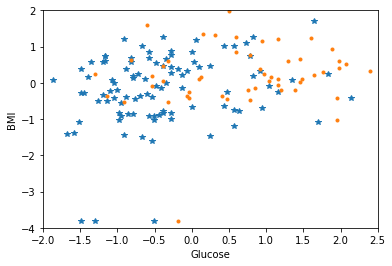

In [373]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

axes = [-2, 2.5, -4, 2, 3]
def plot_clfs(X, y, clf, axes):
    plt.plot(X[:,0][y==0], X[:,1][y==0], "*")
    plt.plot(X[:,0][y==1], X[:,1][y==1], ".")
    plt.xlabel('Glucose')
    plt.ylabel('BMI')
    plt.xlim(axes[0], axes[1])
    plt.ylim(axes[2], axes[3])
    

plot_clfs(pipeline.fit_transform(X_test), y_test, l_svc, axes)
